In [8]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import random
import networkx as nx

1.TODO 2: vector accelaration!!!

# Generate a stochastic graph, with v = $ ceil(\frac{1+\sqrt{1+4*edges}}{2})$ m <=n(n-1)

In [9]:
def oracle_select(ucb_values, k):
    """Selects top-k arms using UCB values."""
    return heapq.nlargest(k, range(len(ucb_values)), key=lambda i: ucb_values[i])

In [ ]:
def generate_stochastic_digraph(num_edges,probs,seed=None):

    if len(probs) != num_edges:
        raise ValueError("probs must have length == num_edges")
    if seed is not None:
        random.seed(seed)
    
    num_vertices = int(np.ceil(np.divide(1+np.sqrt(1+4*num_edges),2)))
   

    # build all possible (u, v) pairs
    possible = [(u, v) for u in range(num_vertices)
                        for v in range(num_vertices) if u != v] # such u !=v

    if len(possible) < num_edges:
        raise ValueError(f"Only {len(possible)} unique edges possible, "
                         f"but num_edges={num_edges}")

    # pick exactly num_edges distinct pairs
    edge_list = random.sample(possible, num_edges)# re-arrange all the edges

    # build the DiGraph
    G = nx.DiGraph()
    G.add_nodes_from(range(num_vertices))
    for (u, v), w in zip(edge_list, probs):
        G.add_edge(u, v, weight=w)
    return G , edge_list


selected_arm: each chosen arm by oracle
super_arm: set of selected arms

In [110]:
random.seed(1)
for i in range(10):
    print(random.random()) # ax+b == c(mod p)

0.13436424411240122
0.8474337369372327
0.763774618976614
0.2550690257394217
0.49543508709194095
0.4494910647887381
0.651592972722763
0.7887233511355132
0.0938595867742349
0.02834747652200631


In [197]:
def IC(G, m, edge_list,super_arm, seed=None):
    if seed is not None: #choose the seed 
        random.seed(seed)

    active = set()
    newly_active = set()
    active_arm = set(super_arm)
    reward = np.zeros(m)  # Count how many were triggered directly

    # First trigger from super_edges
    for idx in super_arm:
        u, v = edge_list[idx]
        if u in active:
            continue
        else:
            active.add(u)
            print(f"The in_point of the selected_arm{idx} u:{u}")
        
        if v not in active and random.random() < G[u][v]['weight']:# whether trigger by Ber(p)
            print(f"The out_point of the selected_arm{idx} v:{v}")
        
            active.add(v)
            newly_active.add(v)
            reward[idx] += 2 # how many points
        else:
            reward[idx] += 1 # if the first successor can not be triggered, we only count the first point
            continue
        
        while newly_active:
            next_round = set()
            for node in newly_active:
                for node_successors in G.successors(node):
                    if node_successors not in active and random.random() < G[node][node_successors]['weight']:
                        active_arm.add(edge_list.index((node,node_successors)) )
                        active.add(node_successors)
                        next_round.add(node_successors)
                        reward[idx] += 1
            newly_active = next_round
            active |= newly_active
    
    return reward, active,active_arm

# Simulation of IC

In [200]:
import numpy as np
import networkx as nx
import random

# random.seed(22)
# Test parameters
num_edges = 15
true_mu = np.random.uniform(0,1,num_edges)#[0.9, 0.8, 0.7, 0.6, 0.5]  # Edge probabilities
k = 2  # Number of super arms to select
seed = 42  # For reproducibility

# Generate graph
G, edge_list = generate_stochastic_digraph(num_edges, true_mu, seed)

print("Generated graph edges:")
print(edge_list)
for u, v in edge_list:
    print(f"Edge {u}->{v} with probability {G[u][v]['weight']}")

# Simulate oracle selection (select top k edges by probability)
true_mu = [G[u][v]['weight'] for u, v in edge_list]
super_arm = oracle_select(true_mu,k)
print("super_arm",super_arm)
# print(f"\nSelected super arms (edges): {super_arms}")

# Run IC model
reward, active,active_arm = IC(G, num_edges, edge_list, super_arm, seed)
print("active_arm: ",active_arm)


Generated graph edges:
[(2, 7), (0, 7), (6, 4), (5, 8), (5, 2), (3, 2), (2, 5), (2, 0), (9, 10), (0, 9), (0, 8), (2, 1), (5, 0), (5, 4), (11, 8)]
Edge 2->7 with probability 0.7715114199574862
Edge 0->7 with probability 0.24509978929449672
Edge 6->4 with probability 0.7442753201985198
Edge 5->8 with probability 0.09287068003672994
Edge 5->2 with probability 0.016457001871998722
Edge 3->2 with probability 0.8306326046996008
Edge 2->5 with probability 0.24070644018157228
Edge 2->0 with probability 0.1946019786663502
Edge 9->10 with probability 0.25824617968055474
Edge 0->9 with probability 0.4835310705297833
Edge 0->8 with probability 0.8963970155616368
Edge 2->1 with probability 0.7734701050321757
Edge 5->0 with probability 0.016384383528544544
Edge 5->4 with probability 0.8199283543462433
Edge 11->8 with probability 0.6543147708607462
super_arm [10, 5]
The in_point of the selected_arm10 u:0
The out_point of the selected_arm10 v:8
The in_point of the selected_arm5 u:3
The out_point of th

In [ ]:
def graph_trigger(G,edge_list,m,mu,k,ucb = None,seed = None):
    if seed != None:
        np.random.seed(seed)
    if ucb.any() == None:
        ucb = mu
    
    super_arm = oracle_select(ucb,k)
    reward,active,active_arm= IC(G, m,edge_list,super_arm, seed=22)
    return reward,super_arm,active_arm

In [149]:
def offline(m,mu_off,T,seed = None):
    if seed != None:
        random.seed(seed)
    N = np.random.uniform(0,T**2,m) # or m*T^2
    mu_hat_off = np.zeros(m)
    for i in range(m):
        mu_hat_off[i] = np.divide(np.random.binomial(N[i],mu_off[i]),N[i])
    return N, mu_hat_off

Remark: should only use once or set seed.

In [204]:
def hybrid(m,k,t,N,mu_hat_off,V,G,edge_list,N_online,mu_hat_on):
    ucb_online = np.zeros(m)
    ucb_hybrid = np.zeros(m)
    

    for i in range(m):
        # Pure online UCB
        log_term = np.log(4 * m * t**3 )

        # N_online
        if N_online[i] == 0:
            ucb_online[i] = 1
        else:
            ucb_online[i] = mu_hat_on[i] + np.sqrt(2 * log_term / (N_online[i]))

        # N[i] + N_online[i]
        if N[i] + N_online[i] == 0:
            ucb_hybrid[i] = 1
        else:
            ucb_hybrid[i] = np.divide(N[i]*mu_hat_off[i] + N_online[i]* mu_hat_on[i], N[i] + N_online[i]) + np.sqrt(2 * log_term / (N_online[i]+N[i])) + np.divide(N[i]*V[i],N[i] + N_online[i])
    ucb = np.minimum(np.minimum(ucb_online, ucb_hybrid), np.ones(m))
    print("ucb_online is:",ucb_online)
    print()
    print("ucb_hybrid is:",ucb_hybrid)
    print()
    print("ucb: ",ucb)
    print()
    reward,super_arm,active_arm = trigger(G,edge_list,m,mu_hat_on,k,ucb,seed = 22)
    for i in active_arm: 
        N_online[i] += 1
        mu_hat_on[i] += np.divide(1 - mu_hat_on[i],N_online[i])
    print("N_online:",N_online)
    print("mu_hat_on: ",mu_hat_on)  
    return reward,N_online,mu_hat_on


# # hybrid simulation


In [ ]:
np.random.seed(22)
m = 70
k = 10
T = 50
true_mu = np.random.uniform(0,1,m) # Adjust : 0 can be changed to 0.5,0.6
V = np.random.uniform(0,1,m) # Adjust: V can be changed
mu_off = np.minimum(np.maximum(true_mu + V, 0),0.98) # Adjust : may fix
gap_online = []
gap_hybrid_unbiased = []
gap_hybrid_biased = []
N_online,mu_hat_on = np.zeros(m),np.zeros(m)

# 2.Build the graph-oracle
N, mu_hat_off = offline(m,mu_off,T)
G,edge_list = generate_stochastic_digraph(m,true_mu,seed=22) # edge_list is like [(0, 2), (2, 3), (0, 1), (0, 3), (1, 3)]
super_arms = oracle_select(true_mu,k) # index of:[max,submax,subsubmax...] 
for t in range(1,300):
    print(f"For t = {t},")
    print()
    reward,N_online,mu_hat_on = hybrid(m,k,t,N,mu_hat_off,V,G,edge_list,N_online,mu_hat_on)
    print("reward: ",reward)


# Main Algorithm

In [13]:
import random
random.random()

0.7944977402612154

In [ ]:
def trigger(super_arm,true_mu):
    reward = np.zeros(len(super_arm))
    observed_arm = []
    for i in super_arm:
        observed_arm.append(i)
        if random.randm() < true_mu[i]: # X_i,t == 1
            reward[len(observed_arm) - 1] = 1
            return reward,observed_arm
    return reward,observed_arm # if 0, it is no arm searched out

In [90]:
def regret(reward_star,reward):
    return reward_star - reward.max()

In [ ]:
def IC(G, m, edge_list,super_arms, seed=None):
    if seed is not None: #choose the seed 
        random.seed(seed)

    active = set()
    newly_active = set()
    reward = np.zeros(m)  # Count how many were triggered directly

    # First trigger from super_edges
    for idx in super_arms:
        u, v = edge_list[idx]
        if random.random() < G[u][v]['weight']:# whether trigger by Ber(p)
            active.add(v)
            newly_active.add(v)
            reward[idx] += 2 # how many points
        else:
            reward[idx] += 1 # if the first successor can not be triggered, we only count the first point
        
        while newly_active:
            next_round = set()
            for node in newly_active:
                for node_successors in G.successors(node):
                    if node_successors not in active and random.random() < G[node][node_successors]['weight']:
                        active.add(node_successors)
                        next_round.add(node_successors)
                        reward[idx] += 1
            newly_active = next_round
    
    return reward, active

C:\Users\Pluviophile\AppData\Local\Temp\ipykernel_24776\365441400.py:11: RuntimeWarning: invalid value encountered in divide
  ucb_hybrid[i] = np.divide(N[i]*mu_off[i] + N_online[i]* mu_hat_on[i], N[i] + N_online[i]) + np.sqrt(2 * log_term / (N_online[i]+N[i] + 1e-10)) + np.divide(N[i]*V[i],N[i] + N_online[i])##


[ 2.  1.  1.  2. 17.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 2.  1.  1.  2. 17.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 2.  1.  1.  2. 17.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 2.  1.  1.  2. 17.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

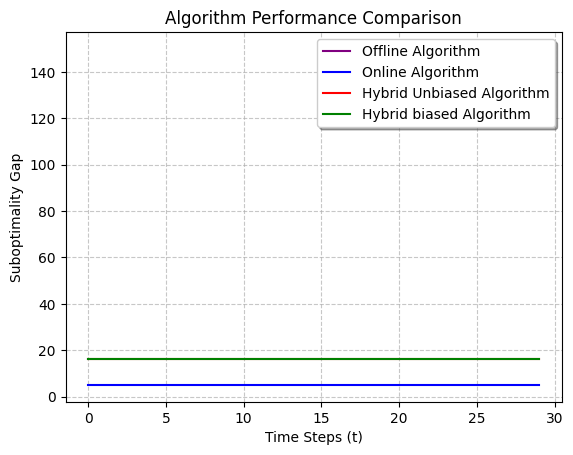

In [98]:
# 1. setting
np.random.seed(22)
m = 70
k = 5
T = 30
true_mu = np.random.uniform(0,1,m) # Adjust : 0 can be changed to 0.5,0.6
V = np.random.uniform(0,1,m) # Adjust: V can be changed
mu_off = np.minimum(np.maximum(true_mu + V, 0),0.98) # Adjust : may fix
gap_online = []
gap_hybrid_unbiased = []
gap_hybrid_biased = []

# 2.Build the graph-oracle
G,edge_list = generate_stochastic_digraph(m,true_mu) # edge_list is like [(0, 2), (2, 3), (0, 1), (0, 3), (1, 3)]
super_arm_oracle = oracle_select(true_mu,k)
reward_oracle,active = IC(G, m,edge_list,super_arm_oracle)
reward_star = reward_oracle.sum()

# 3. do offline, online, hybrid-unbiased, hybrid-biased
# 3.1 offline
N, mu_hat_off = offline(m,mu_off,T)
super_arms_off = oracle_select(mu_hat_off,k)
reward_off,active = IC(G, m,edge_list,super_arms_off)
gap_offline = regret(reward_star,reward_off) * T


# 3.2 online, hybrid-unbiased, hybrid-biased
for t in range(1, T+1):
    reward_online = hybrid(m,k,t,np.zeros(m),np.zeros(m),V,G,edge_list)# online hybrid(m,k,t,N,mu_off,V,G,edge_list)
    reward_hybrid_unbiased = hybrid(m,k,t,N,mu_off,np.zeros(m),G,edge_list)
    reward_hybrid_biased = hybrid(m,k,t,N,mu_off,V,G,edge_list)
    print(reward_online)
    gap_online.append(abs(regret(reward_star,reward_online)))
    gap_hybrid_unbiased.append(regret(reward_star,reward_hybrid_unbiased))
    gap_hybrid_biased.append(regret(reward_star,reward_hybrid_biased))

# 4.Plot
plt.plot(gap_offline, color='purple', label='Offline Algorithm')
plt.plot(gap_online, color='blue', label='Online Algorithm')
plt.plot(gap_hybrid_unbiased, color='red', label='Hybrid Unbiased Algorithm')
plt.plot(gap_hybrid_biased, color='green', label='Hybrid biased Algorithm')

plt.xlabel("Time Steps (t)")
plt.ylabel("Suboptimality Gap")
plt.title("Algorithm Performance Comparison")

# Customize the legend location and appearance
plt.legend(loc='upper right', frameon=True, shadow=True)

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Remark:
1. online is generated once for all, adjust if you want to trigger for every t.

In [ ]:
# 1) build your graph as before
np.random.seed(22)
m = 20
k = 5
T = 5
true_mu = np.random.uniform(0,1,m) # Adjust : 0 can be changed to 0.5,0.6
V = np.random.uniform(0,1,m) # Adjust: V can be changed
mu_off = min(max(true_mu + V, 0),1)
G,edge_list = generate_stochastic_digraph(
    m,
    true_mu,
    seed=42
) # edge_list is like [(0, 2), (2, 3), (0, 1), (0, 3), (1, 3)]

# 2) choose your super-arm
super_arm = oracle_select(true_mu,k)

print("superarm is:",super_arm)

# 3) run one cascade and get reward
reward, activated = IC(G, edge_list, super_arm, seed=42)


print("Reward (newly activated nodes):", reward)

# Run simulations
N= offline(m, k,T,true_mu)
V = np.random.uniform(0,1,m)
online_gaps, mu_on= online(m,k,T,true_mu)
bias = np.random.uniform(-1,1)
mu_off = max(min(0,mu_on),1)


hybrid_gaps_biased = hybrid(m,k,T,true_mu,N, mu_off,V)
hybrid_gaps_unbiased = hybrid(m,k,T,true_mu,N,true_mu,V1)
# print(hybrid_gaps)

superarm is: [17, 3, 12, 9, 16]
Reward (newly activated nodes): 1


In [ ]:


def online(m,k,T,true_mu):
    optimal_reward = np.max(true_mu)
    N_online = np.zeros(m) # Number of times arm i is played
    mu_on = np.random.uniform(0 ,1 ,m)# m-D uniform
    ucb_online = np.zeros(m)
    suboptimal_gaps = []
    
    # initial_mu = np.random.uniform(0 ,1 ,m)
    # N_online = np.random.binomial(1, initial_mu[:, np.newaxis], size=(m, 1))

    for t in range(1,T+1):
        # N_online += np.random.binomial(1, mu_on) # generate m*1 matrix
        for i in range(m):
            # Pure online UCB

            # update ucb 
            log_term = np.log(4 * m * t**3) ## TODO 0: delta is self-added
            ucb_online[i] = mu_on[i] + np.sqrt(2 * log_term / (N_online[i] + 1e-10)) # TODO 1: is 1e-10 ok？

        # control it to be smaller than 1
        ucb = np.minimum(ucb_online,1) ## Remark new
        top_k_mu_indices = oracle_select(ucb,k)

        for i in top_k_mu_indices: 
            X = np.random.binomial(1,true_mu) ## TODO 3: if right the way I formulate reward; generate vector length of ucb, has 1 w.p. ucb[i]
            N_online[i] += 1
            mu_on[i] += np.divide(X[i] - mu_on[i],N_online[i])
        # print(mu_on)

        # generate gap
        gap =  optimal_reward -  max(mu_on[top_k_mu_indices])
        suboptimal_gaps.append(gap)
    return suboptimal_gaps,mu_on

---

In [ ]:
def hybrid(m,k,T,true_mu,N, mu_off,V,delta = 0.1):
    optimal_reward = np.max(true_mu)
    N_online = np.zeros(m)
    mu_on = np.random.uniform(0 ,1 ,m)
    ucb_online = np.zeros(m)
    ucb_hybrid = np.zeros(m)
    suboptimal_gaps = []
    N_online = np.random.binomial(1, mu_on[:, np.newaxis], size=(m, 1))

    for i in range(m):
        r = np.random.binomial(1, true_mu[i])
        N[i] += 1
        mu_on[i] = r ##???

    for t in range(1,T+1):
        for i in range(m):
            # Pure online UCB
            log_term = np.log(4 * m * t**3 / delta)
            ucb_online[i] = mu_on[i] + np.sqrt(2 * log_term / (N_online[i] + 1e-10)) # TODO 1: is 1e-10 ok？
            ucb_hybrid[i] = np.divide(N[i]*mu_off[i] + N_online[i]* mu_on[i], N[i] + N_online[i]) + np.sqrt(2 * log_term / (N_online[i]+N[i] + 1e-10)) + np.divide(N[i]*V[i],N[i] + N_online[i])##
        ucb = np.minimum(np.minimum(ucb_online, ucb_hybrid), 1.0)
        top_k_mu_indices = oracle_select(ucb,k)
        for i in top_k_mu_indices: # TODO 2: vector accelaration!!!
            reward = np.random.binomial(1, ucb)
            N_online[i] = N_online[i] + 1
            mu_on[i] = mu_on[i] + np.divide(reward[i] - mu_on[i],N_online[i])## TODO 3: if right
        # generate gap
        gap = - optimal_reward + max(ucb[top_k_mu_indices])
        suboptimal_gaps.append(gap)
    return suboptimal_gaps

true_mu: [0.25092362 0.04609582 0.67681624 0.04346949 0.1164237  0.60386569
 0.19093066]

# Visualization of the Graph

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(G):
    pos = nx.spring_layout(G, seed=42)  # or use kamada_kawai_layout, shell_layout, etc.
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, arrowsize=20)
    
    # Draw edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})
    
    plt.title("Generated Stochastic DiGraph")
    plt.axis('off')
    plt.show()

# Generate a sample graph
m = 10  # number of edges
probs = np.random.uniform(0.1, 0.9, m)  # edge weights
G, edge_list = generate_stochastic_digraph(m, probs, seed=42)

# Draw it
draw_graph(G)
